In [1]:
# Bibliotecas
import pandas as pd                       # Dados, dataframe
import numpy as np                        # Calculos, arrays
import matplotlib.pyplot as plt           # Gráficos
import seaborn as sns                     # Gráficos
from datetime import datetime, timedelta  # Trabalhar com Data e Hora

In [2]:
# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🔧 INICIANDO ANÁLISE DE EFICIÊNCIA ENERGÉTICA")
print("=" * 50)

🔧 INICIANDO ANÁLISE DE EFICIÊNCIA ENERGÉTICA


In [3]:
# 1. DADOS SIMULADOS
print("\n📊 GERANDO DADOS DE CONSUMO ENERGRÉTICO...")

np.random.seed(42)
start_date = datetime(2025, 1, 1)
dates = []
current = start_date

for _ in range(30 * 24 * 4): # 30 dias, 24 horas por dia, 4 intervalos (de 15 minutos) 2880 entradas no df
    dates.append(current)
    current += timedelta(minutes=15)

df = pd.DataFrame({'timestamp': dates})
df['hora'] = df['timestamp'].dt.hour
df['dia_semana'] = df['timestamp'].dt.dayofweek
df['final_semana'] = df['dia_semana'].isin([5, 6]).astype(int)
df['turno'] = pd.cut(df['hora'],
                    bins=[-1, 6, 12, 18, 24],
                    labels=['Madrugada', 'Manhã', 'Tarde', 'Noite'])

def simular_ocupacao(hora, dia_semana, final_semana):
    if final_semana:
        return np.random.randint(0, 5)
    if 8 <= hora <= 18:
        base = 30
        if 10 <= hora <= 12 or 14 <= hora <= 16:
            base = 45
        return np.random.randint(base-10, base+5)
    else:
        return np.random.randint(0, 15)

df['ocupacao'] = df.apply(lambda x: simular_ocupacao(x['hora'], x['dia_semana'], x['final_semana']), axis=1)

def simular_consumo(linha):
    hora = linha['hora']
    ocupacao = linha['ocupacao']
    final_semana = linha['final_semana']

    base_kwh = 2.5

    if 6 <= hora <= 20:
        iluminacao = base_kwh * 0.3 * (ocupacao/50)
    else:
        iluminacao = base_kwh * 0.1

    if 8 <= hora <= 19 and not final_semana:
        ar_condicionado = base_kwh * 0.5 * (1 + ocupacao/60)
    else:
        ar_condicionado = base_kwh * 0.1

    equipamentos = base_kwh * 0.4 * (ocupacao/40) + base_kwh * 0.2

    ruido = np.random.normal(0, 0.1)
    total = iluminacao + ar_condicionado + equipamentos + ruido
    total = max(0.5, total)

    return iluminacao, ar_condicionado, equipamentos, total

consumo_data = df.apply(simular_consumo, axis=1, result_type='expand')
df[['iluminacao_kwh', 'ar_condicionado_kwh', 'equipamentos_kwh', 'consumo_total_kwh']] = consumo_data

picos_indices = np.random.choice(df.index, size=20, replace=False)
df.loc[picos_indices, 'consumo_total_kwh'] *= 1.8

df = df[['timestamp', 'hora', 'dia_semana', 'final_semana', 'turno', 'ocupacao',
         'iluminacao_kwh', 'ar_condicionado_kwh', 'equipamentos_kwh', 'consumo_total_kwh']]

df.to_csv('dados_consumo_energia_escritorio.csv', index=False)

print("✅ Dados gerados e salvos com sucesso!")


📊 GERANDO DADOS DE CONSUMO ENERGRÉTICO...
✅ Dados gerados e salvos com sucesso!



📈 INICIANDO ANÁLISE EXPLORATÓRIA...


/tmp/ipython-input-359734637.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  consumo_turno = df.groupby('turno')['consumo_total_kwh'].mean()


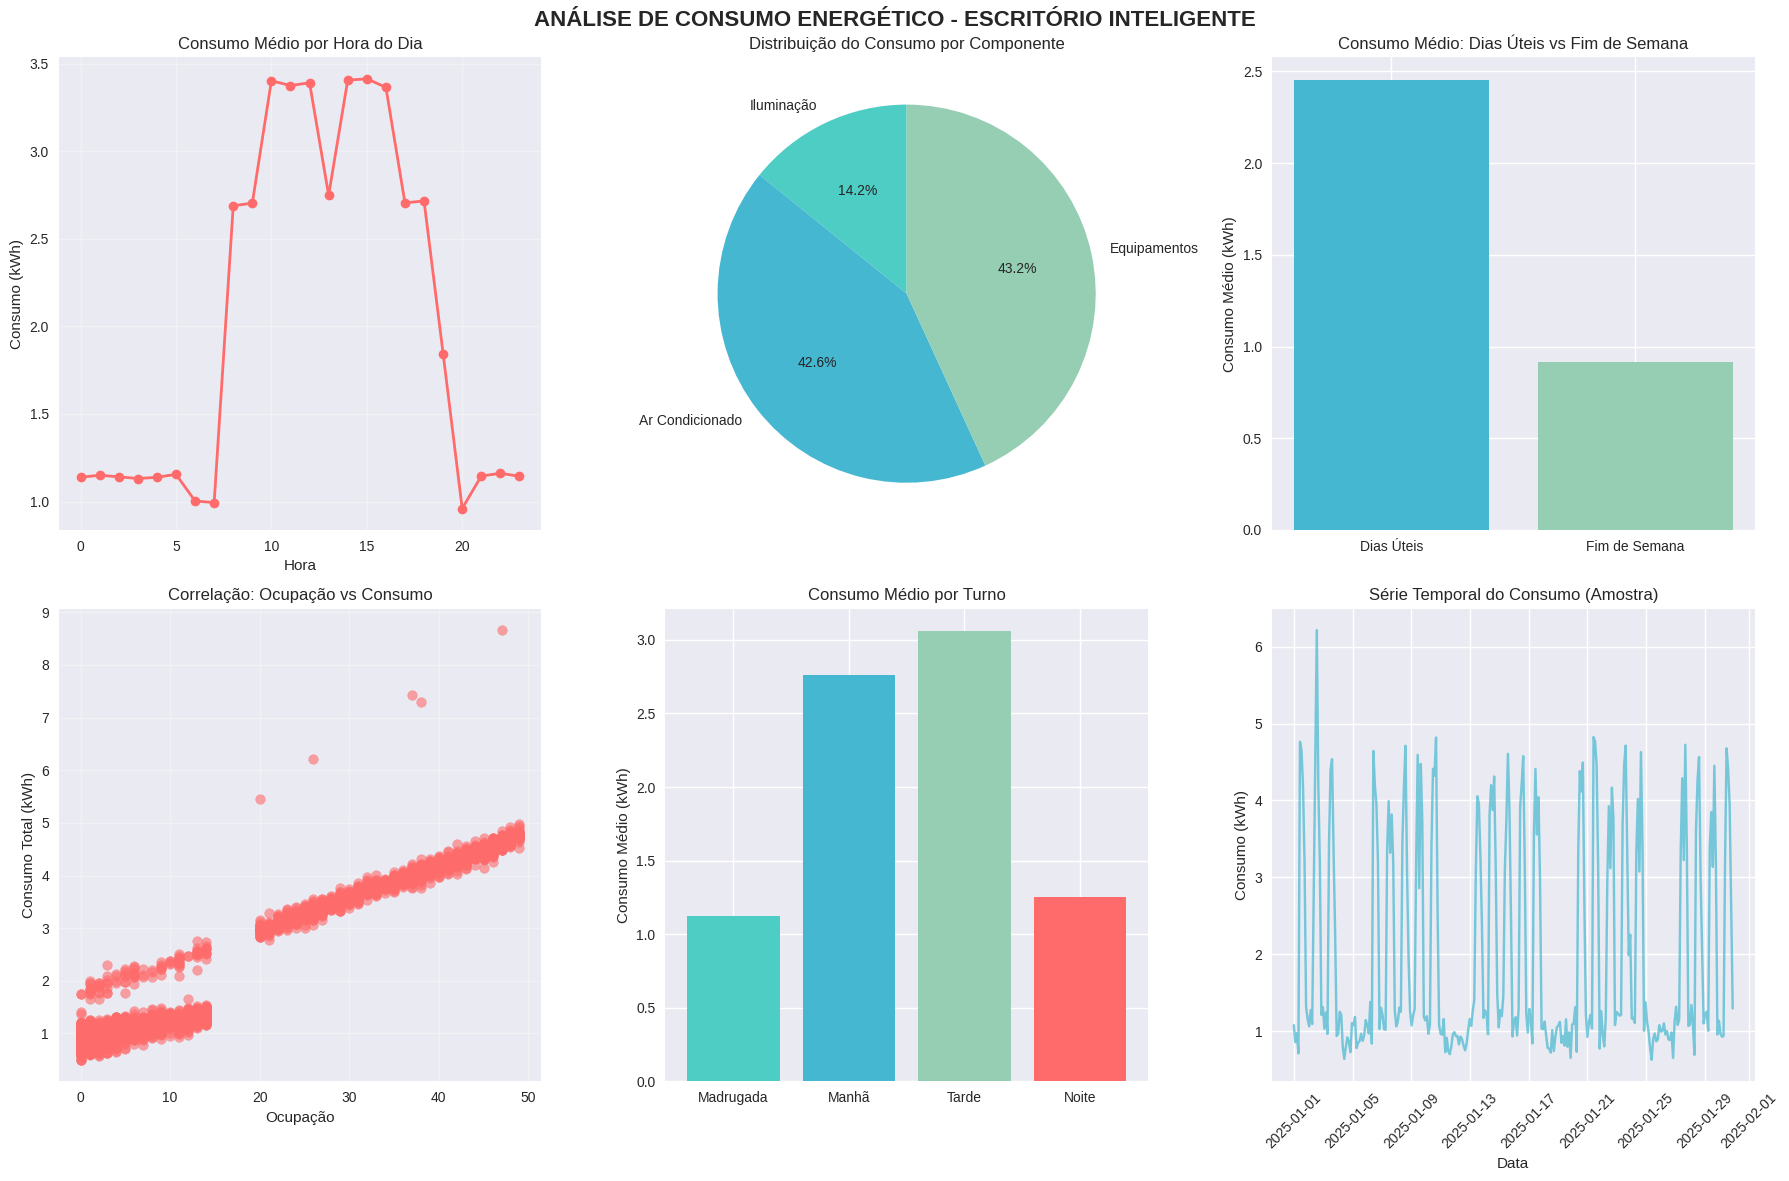

In [4]:
# 2. ANÁLISE EXPLORATÓRIA
print("\n📈 INICIANDO ANÁLISE EXPLORATÓRIA...")

# Criar figura para os gráficos
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('ANÁLISE DE CONSUMO ENERGÉTICO - ESCRITÓRIO INTELIGENTE', fontsize=16, fontweight='bold')

# Gráfico 1: Consumo por horário do dia
consumo_por_hora = df.groupby('hora')['consumo_total_kwh'].mean()
axes[0,0].plot(consumo_por_hora.index, consumo_por_hora.values, marker='o', linewidth=2, color='#FF6B6B')
axes[0,0].set_title('Consumo Médio por Hora do Dia')
axes[0,0].set_xlabel('Hora')
axes[0,0].set_ylabel('Consumo (kWh)')
axes[0,0].grid(True, alpha=0.3)

# Gráfico 2: Consumo por componente
componentes = ['iluminacao_kwh', 'ar_condicionado_kwh', 'equipamentos_kwh']
consumo_componentes = df[componentes].sum()
cores = ['#4ECDC4', '#45B7D1', '#96CEB4']
axes[0,1].pie(consumo_componentes.values, labels=['Iluminação', 'Ar Condicionado', 'Equipamentos'],
              autopct='%1.1f%%', colors=cores, startangle=90)
axes[0,1].set_title('Distribuição do Consumo por Componente')

# Gráfico 3: Consumo dias úteis vs fim de semana
consumo_dia_semana = df.groupby('final_semana')['consumo_total_kwh'].mean()
axes[0,2].bar(['Dias Úteis', 'Fim de Semana'], consumo_dia_semana.values, color=['#45B7D1', '#96CEB4'])
axes[0,2].set_title('Consumo Médio: Dias Úteis vs Fim de Semana')
axes[0,2].set_ylabel('Consumo Médio (kWh)')

# Gráfico 4: Correlação entre ocupação e consumo
axes[1,0].scatter(df['ocupacao'], df['consumo_total_kwh'], alpha=0.6, color='#FF6B6B')
axes[1,0].set_title('Correlação: Ocupação vs Consumo')
axes[1,0].set_xlabel('Ocupação')
axes[1,0].set_ylabel('Consumo Total (kWh)')
axes[1,0].grid(True, alpha=0.3)

# Gráfico 5: Consumo por turno
consumo_turno = df.groupby('turno')['consumo_total_kwh'].mean()
axes[1,1].bar(consumo_turno.index, consumo_turno.values, color=['#4ECDC4', '#45B7D1', '#96CEB4', '#FF6B6B'])
axes[1,1].set_title('Consumo Médio por Turno')
axes[1,1].set_ylabel('Consumo Médio (kWh)')

# Gráfico 6: Série temporal do consumo
df_amostra = df.iloc[::10]  # Amostrar para não sobrecarregar o gráfico
axes[1,2].plot(df_amostra['timestamp'], df_amostra['consumo_total_kwh'], alpha=0.7, color='#45B7D1')
axes[1,2].set_title('Série Temporal do Consumo (Amostra)')
axes[1,2].set_xlabel('Data')
axes[1,2].set_ylabel('Consumo (kWh)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('analise_consumo_energia.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# 3. IDENTIFICAÇÃO DE DESPERDÍCIOS
print("\n🔍 IDENTIFICANDO OPORTUNIDADES DE ECONOMIA...")

# Calcular métricas importantes
consumo_total_mensal = df['consumo_total_kwh'].sum()
consumo_dias_uteis = df[df['final_semana'] == 0]['consumo_total_kwh'].sum()
consumo_fim_semana = df[df['final_semana'] == 1]['consumo_total_kwh'].sum()
consumo_madrugada = df[df['turno'] == 'Madrugada']['consumo_total_kwh'].sum()

# Identificar desperdícios
desperdicio_fim_semana = consumo_fim_semana * 0.6  # Estimando 60% como desperdício
desperdicio_madrugada = consumo_madrugada * 0.7    # Estimando 70% como desperdício
total_desperdicio_estimado = desperdicio_fim_semana + desperdicio_madrugada

print(f"""
📊 MÉTRICAS DE CONSUMO:
   • Consumo Total Mensal: {consumo_total_mensal:,.2f} kWh
   • Consumo em Dias Úteis: {consumo_dias_uteis:,.2f} kWh
   • Consumo em Fins de Semana: {consumo_fim_semana:,.2f} kWh
   • Consumo na Madrugada: {consumo_madrugada:,.2f} kWh

\n💡 OPORTUNIDADES IDENTIFICADAS:
   • Desperdício estimado em fins de semana: {desperdicio_fim_semana:,.2f} kWh
   • Desperdício estimado na madrugada: {desperdicio_madrugada:,.2f} kWh
   • TOTAL DE DESPERDÍCIO ESTIMADO: {total_desperdicio_estimado:,.2f} kWh""")


🔍 IDENTIFICANDO OPORTUNIDADES DE ECONOMIA...

📊 MÉTRICAS DE CONSUMO:
   • Consumo Total Mensal: 5,883.61 kWh
   • Consumo em Dias Úteis: 5,181.72 kWh
   • Consumo em Fins de Semana: 701.89 kWh
   • Consumo na Madrugada: 943.04 kWh


💡 OPORTUNIDADES IDENTIFICADAS:
   • Desperdício estimado em fins de semana: 421.14 kWh
   • Desperdício estimado na madrugada: 660.13 kWh
   • TOTAL DE DESPERDÍCIO ESTIMADO: 1,081.27 kWh


In [6]:
# 4. SIMULAÇÃO DE ENERGIA RENOVÁVEL (Opção C)
print("\n🌱 SIMULANDO ADOÇÃO DE ENERGIA SOLAR...")

# Supondo que 30% do consumo pode ser gerado por energia solar
capacidade_solar_kw = 20  # Sistema de 20kW
geracao_solar_diaria = capacidade_solar_kw * 5 * 0.8  # 5 horas pico, 80% eficiência
geracao_solar_mensal = geracao_solar_diaria * 30

economia_solar = min(geracao_solar_mensal, consumo_total_mensal * 0.3)

print(f"""
⚡ SIMULAÇÃO DE ENERGIA SOLAR:
   • Capacidade do sistema: {capacidade_solar_kw} kW
   • Geração mensal estimada: {geracao_solar_mensal:,.2f} kWh
   • Economia potencial com solar: {economia_solar:,.2f} kWh""")


🌱 SIMULANDO ADOÇÃO DE ENERGIA SOLAR...

⚡ SIMULAÇÃO DE ENERGIA SOLAR:
   • Capacidade do sistema: 20 kW
   • Geração mensal estimada: 2,400.00 kWh
   • Economia potencial com solar: 1,765.08 kWh


In [11]:
# 5. CÁLCULO DE GANHOS
print("\n💰 CALCULANDO GANHOS AMBIENTAIS E ECONÔMICOS...")

# Tarifa de energia (R$/kWh)
tarifa_energia = 0.80  # R$/kWh

# Economia total potencial
economia_total_kwh = total_desperdicio_estimado + economia_solar
economia_total_reais = economia_total_kwh * tarifa_energia

# Benefícios ambientais
co2_evitado_kg = economia_total_kwh * 0.1  # 0.1 kg CO2 por kWh
arvores_salvas = co2_evitado_kg / 6000     # Cada árvore absorve ~6kg CO2/ano

print(f"""
💵 GANHOS ECONÔMICOS:")
   • Economia total de energia: {economia_total_kwh:,.2f} kWh/mês
   • Economia financeira: R$ {economia_total_reais:,.2f}/mês
   • Retorno anual: R$ {economia_total_reais * 12:,.2f}

🌍 GANHOS AMBIENTAIS:
   • CO2 evitado: {co2_evitado_kg:,.2f} kg/mês""")


💰 CALCULANDO GANHOS AMBIENTAIS E ECONÔMICOS...

💵 GANHOS ECONÔMICOS:")
   • Economia total de energia: 2,846.35 kWh/mês
   • Economia financeira: R$ 2,277.08/mês
   • Retorno anual: R$ 27,324.95

🌍 GANHOS AMBIENTAIS:
   • CO2 evitado: 284.63 kg/mês


In [8]:
# 6. RECOMENDAÇÕES
print(f"""
\n🎯 RECOMENDAÇÕES PARA IMPLANTAÇÃO:

1. ⏰ AUTOMAÇÃO DE DESLIGAMENTO
   • Implementar sistema automático para desligar equipamentos não essenciais
   • Horário: 19h às 7h em dias úteis e 24h em fins de semana

\n2. 🌞 SISTEMA DE ENERGIA SOLAR
   • Instalar sistema fotovoltaico de 20kW
   • Redução de 30% na conta de energia

\n3. 📊 MONITORAMENTO EM TEMPO REAL
   • Dashboard para acompanhamento do consumo
   • Alertas para consumos anormais

\n4. 💡 TROCA PARA LED E SENSORES
   • Substituir lâmpadas fluorescentes por LED
   • Instalar sensores de presença
""")
print("\n" + "=" * 50)

print("""
📁 Arquivos gerados:
   • dados_consumo_energia_escritorio.csv
   • analise_consumo_energia.png""")



🎯 RECOMENDAÇÕES PARA IMPLANTAÇÃO:

1. ⏰ AUTOMAÇÃO DE DESLIGAMENTO
   • Implementar sistema automático para desligar equipamentos não essenciais
   • Horário: 19h às 7h em dias úteis e 24h em fins de semana


2. 🌞 SISTEMA DE ENERGIA SOLAR
   • Instalar sistema fotovoltaico de 20kW
   • Redução de 30% na conta de energia


3. 📊 MONITORAMENTO EM TEMPO REAL
   • Dashboard para acompanhamento do consumo
   • Alertas para consumos anormais


4. 💡 TROCA PARA LED E SENSORES
   • Substituir lâmpadas fluorescentes por LED
   • Instalar sensores de presença



📁 Arquivos gerados:
   • dados_consumo_energia_escritorio.csv
   • analise_consumo_energia.png
